<a href="https://www.kaggle.com/code/tirendazacademy/emotion-analysis-with-bert-and-tensorflow?scriptVersionId=151313973" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Load Emotion Dataset

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

# Preprocess

In [5]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [6]:
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [7]:
emotions_encoded = emotions.map(tokenize, batched=True,batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Evaluate

In [9]:
!pip install -q evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
import evaluate

accuracy = evaluate.load("accuracy")

In [11]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train

In [12]:
id2label = {0: "sadness", 1: "joy", 2:"love", 3:"anger", 4:"fear", 5: "suprise"}
label2id = {"sadness":0, "joy":1, "love":2, "anger":3, "fear":4, "suprise":5}

In [13]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## Login to HuggingFace

In [14]:
from huggingface_hub import notebook_login

notebook_login()

## Prepare the Dataset

In [15]:
tf_train_set = model.prepare_tf_dataset(
    emotions_encoded["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    emotions_encoded["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Compile

In [16]:
import tensorflow as tf

optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer)  # No loss argument!

In [17]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [18]:
from transformers.keras_callbacks import PushToHubCallback

push_to_hub_callback = PushToHubCallback(
    output_dir="emotion-analysis-with-distilbert",
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/Tirendaz/emotion-analysis-with-distilbert into local empty directory.


Download file tf_model.h5:   0%|          | 8.00k/256M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [19]:
model.fit(x=tf_train_set, 
          validation_data=tf_validation_set, 
          epochs=2, 
          callbacks=[metric_callback, push_to_hub_callback])

Epoch 1/2
1000/1000 [==============================] - 176s 147ms/step - loss: 0.3754 - val_loss: 0.1718 - accuracy: 0.9255
Epoch 2/2
1000/1000 [==============================] - 112s 112ms/step - loss: 0.1310 - val_loss: 0.1362 - accuracy: 0.9320


# Inference

In [20]:
custom_text="I watched a movie yesterday. It was really bad."

In [21]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", 
                      model="Tirendaz/emotion-analysis-with-distilbert")

Some layers from the model checkpoint at Tirendaz/emotion-analysis-with-distilbert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Tirendaz/emotion-analysis-with-distilbert and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
inputs = tokenizer(custom_text, return_tensors="tf")
logits = model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'sadness'

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


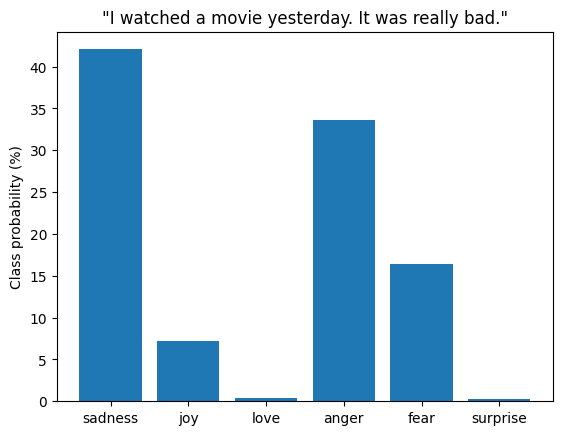

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
labels = emotions["train"].features["label"].names
preds=classifier(custom_text, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()

Thanks for reading. If you enjoyed this notebook, don't forget to upvote ☺️

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [X](http://x.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) 😎